In [1]:
import mlflow
import pandas as pd
import numpy as np

model_name = "../best-model"

loaded_model = mlflow.sklearn.load_model(model_name)

#read feature
df = pd.read_csv('feature_ml.csv')
df = df.set_index('date')

#for interval
t_score = pd.read_csv('t_&_std.csv')['t_score'][0]
prediction_std = pd.read_csv('t_&_std.csv')['prediction_std'][0]

#create a frame
forecast_horizon = 48
start_date = pd.to_datetime(df.index[-1]) + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])

# got this value from last week mean
forecast_df['working_hours_lawyers'] = 16 
forecast_df['late_hours_lawyers'] = 5

# read forecasted value
web_vis = pd.read_csv('webvisitor_forecast_1109.csv')
web_vis = web_vis.rename(columns={'Unnamed: 0':'date', 'forecasted_value':'web_vis_proj'})
web_vis['date'] = pd.to_datetime(web_vis['date'])
web_vis.set_index('date', inplace=True)
web_vis = web_vis[web_vis.index > '2023-11-13']

forecast_temp = pd.merge(forecast_df, web_vis, left_index=True, right_index=True)
forecast_temp.head()


forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = df.iloc[-1, 0:7].to_numpy().reshape(1, -1)

columns_to_append = ['working_hours_lawyers', 'late_hours_lawyers', 'web_vis_proj']

for i in range(forecast_horizon):
    latest_data_row = np.append(latest_data_row, forecast_temp[columns_to_append].iloc[i])
    latest_data_row = latest_data_row.reshape(1, -1)
    predicted_result = loaded_model.predict(latest_data_row)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row[0]))
    
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[0:7].reshape(1, -1)
    
forecast_value = [array[0] for array in forecast_array]

prediction_interval_lower = forecast_value - t_score * prediction_std
prediction_interval_upper = forecast_value + t_score * prediction_std

forecast_temp["forecasted_value"] = forecast_value
forecast_temp["lower_value"] = prediction_interval_lower
forecast_temp["upper_value"] = prediction_interval_upper

forecast_final = forecast_temp[['forecasted_value', 'lower_value', 'upper_value']].copy()
forecast_final = forecast_final.reset_index()
forecast_final = forecast_final.rename(columns={'index':'date'})

# save the result to bigquery/google bucket
# forecast_final.to_csv('forecasted_result.csv,')

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fea

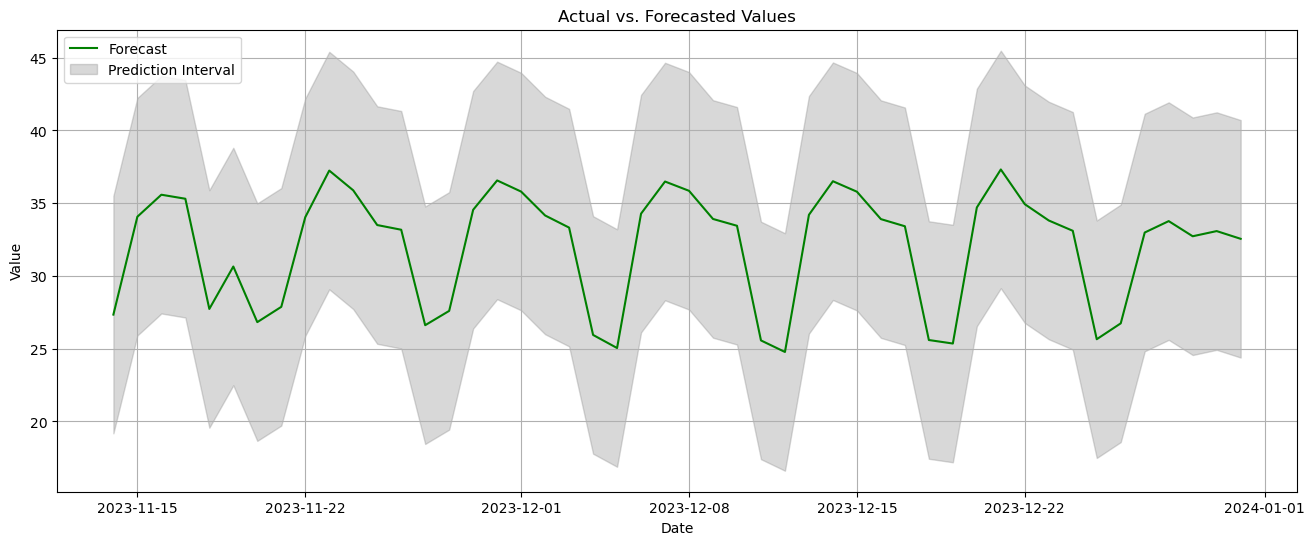

In [2]:
import matplotlib.pyplot as plt
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(16, 6))
plt.plot(forecast_final['date'], forecast_final['forecasted_value'], label='Forecast', color='Green')
# Add prediction intervals
plt.fill_between(forecast_final['date'], forecast_final['lower_value'], forecast_final['upper_value'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()